# Transfomer for time series data

## Objectives of this Lab

- Develop an understanding of the fundamental concepts behind Transformers and implement a basic version.
- Gain an introductory understanding of applications of deep learning in finance.
- Assess and reinforce your existing knowledge of deep learning.
- Explore the potential to apply these skills effectively—on the journey to becoming an expert (and maybe... wealthy). 🚀


In this lab, we aim to build a model capable of predicting trends in stock values, laying the groundwork for a potential trading bot. To achieve this, we will leverage the Transformer Encoder, which is well-suited for capturing complex temporal dependencies in financial data.


In [1]:
!pip install pytorch-lightning
!pip install wandb
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
# Standard Libraries
import os
import copy
import math
import random
from typing import Optional, List

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import MNIST

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import seed_everything

# Scientific Libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from PIL import Image
import matplotlib.pyplot as plt

# Computer Vision
import cv2
import cv2 as cv

# Wandb and Financial Data
import wandb
import yfinance as yf

# Constants
USE_COLAB = True
CONTENT_DIR = "/content" if USE_COLAB else "."

if not wandb.login():
    raise ValueError("WandDB authentification failed.")

seed_everything(42)


def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jeremy-tran-ensea (jeremy-tran-ensea-ensea). Use `wandb login --relogin` to force relogin
Seed set to 42


# Transformer

## Before Transformers: Sequence Modeling Challenges

Before the advent of Transformers, sequence modeling tasks primarily relied on recurrent neural network (RNN) architectures, such as vanilla RNNs, LSTMs (Long Short-Term Memory networks), and GRUs (Gated Recurrent Units). These architectures were designed to process data sequentially, making them well-suited for tasks where temporal or sequential relationships are critical, such as language modeling, translation, and time-series analysis.

**Strengths of RNNs, LSTMs, and GRUs:**
- Sequential Processing: RNNs inherently model temporal dependencies by processing input data token by token.
- Memory Mechanisms: LSTMs and GRUs improve on standard RNNs by incorporating gating mechanisms to capture long-range dependencies and mitigate the vanishing gradient problem.

**Key Challenges and Limitations:**
- Sequential Computation: The sequential nature of RNNs makes training and inference slow, as tokens must be processed in order. This limits parallelization and scalability.
- Long-Term Dependencies: Despite improvements, capturing very long-range dependencies remains challenging. Models often fail to effectively propagate information over extended sequences.
- Gradient Issues: RNNs can suffer from vanishing or exploding gradients, making it difficult to train deep models on long sequences.
Fixed-Length Representations: Many traditional architectures compress variable-length sequences into fixed-size vectors, potentially losing important information.


## The Need for a Paradigm Shift:

The limitations of RNN-based architectures inspired the search for alternatives capable of:
- Parallelizing computation for faster training and inference.
- Handling long-range dependencies efficiently.
- Representing sequences in a more flexible and scalable manner.

This led to the development of Transformers, which utilize self-attention mechanisms to address these challenges, transforming how sequence modeling is approached.

## Attention: The Core of Transformers

Attention, self-attention, and multi-head attention are central to the Transformer architecture. These mechanisms enable the model to focus on the most relevant parts of the input, dynamically identifying important regions or tokens for a given task.
- Self-Attention: Computes relationships between all tokens in the input, capturing both local and global dependencies effectively.
- Multi-Head Attention: Extends self-attention by processing multiple subspaces simultaneously, allowing the model to focus on diverse aspects of the input (e.g., syntax, semantics).

Advantages of Attention:
- Processes tokens in parallel, enabling faster computation.
- Captures long-range dependencies across the input.
- Improves representational flexibility for complex relationships.
Attention mechanisms form the backbone of the Transformer's ability to model sequences efficiently and effectively.

## Architecture Overview

The Transformer is a neural network architecture fundamentally built on attention mechanisms. It is structured as an **encoder-decoder** framework, with distinct roles for each component:
- **Encoder:** Maps an input sequence of symbol representations $(x_1, \dots, x_n)$ to a sequence of intermediate representations $(z_1, \dots, z_n)$.  
- **Decoder:** Takes the encoder's output $z$ and generates an output sequence $(y_1, \dots, y_m)$.  

A key characteristic of the decoder is that it operates in an **auto-regressive** manner: at each time step, it uses the previously generated symbols as additional inputs to generate the next symbol in the sequence. This property ensures that the output is generated sequentially, preserving dependencies between tokens.

<img src="https://miro.medium.com/max/1400/1*BHzGVskWGS_3jEcYYi6miQ.png" width= 400>    
<img src="https://miro.medium.com/max/1400/1*BHzGVskWGS_3jEcYYi6miQ.png" width= 400>

# Positional Encoding

Transformers operate on sequences of data where the order of elements is critical. To illustrate the importance of order, consider the following example:

> Vivre pour manger ≠ Manger pour vivre.

In recurrent architectures such as RNNs, LSTMs, or GRUs, the sequential nature of processing inherently captures positional information, as tokens are processed in order. However, Transformers lack this sequential mechanism due to their parallelized processing of input sequences. This raises an important question:

How can we encode the positional information of tokens within the Transformer architecture?

The solution proposed by the authors of the Transformer model involves incorporating positional information directly into the input embeddings. This is achieved by adding a positional encoding vector to each token's embedding. These positional encodings effectively convey the position of each token within the sequence, enabling the model to understand the relative and absolute order of tokens.

Formally, the positional encoding for a token at position $pos$ and dimension $i$ is defined as:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$

where:
- $pos$ is the position of the token in the sequence.
- $i$ refers to the dimension of the positional encoding.
- $d_{\text{model}}$ is the dimensionality of the model (embedding dimension).

The wavelength form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$ across the dimensions. This function allows the model to learn representations that consider both the absolute and relative positions of tokens in the sequence.


# 1 - Data

## 1.1 Data Collection

You are encouraged to download and analyze any stock data of your choice, making the learning experience both practical and customizable.
You need table of stock data with the following columns:
- Date
- Open
- High
- Low
- Close
- Volume
- Adj Close

You can obtain stock data in several ways:
- download the data from any source that provide a "csv"-like file
    * S&P500 : https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC,  https://www.nasdaq.com/market-activity/index/spx/historical
    * Bitcoin : https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD,...
    * Gold : https://finance.yahoo.com/quote/GC%3DF/history?p=GC%3DF,..
- use the `yfinance` library to download the data directly from the Yahoo Finance website
    - S&P500: "^GSPC"
    - Bitcoin: "BTC-USD"
    - Gold: "GC=F"

Note: A longer historical period is essential to capture trends and train the model effectively.

In [3]:
import yfinance as yf
import pandas as pd

# option 1
# data = pd.read_csv(...)

# option 2
data = yf.Ticker("GC=F").history("1mo")
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-11-18 00:00:00-05:00,2591.699951,2610.699951,2589.399902,2610.600098,136,0.0,0.0
2024-11-19 00:00:00-05:00,2621.899902,2627.699951,2619.300049,2627.100098,87,0.0,0.0
2024-11-20 00:00:00-05:00,2638.500000,2648.199951,2638.500000,2648.199951,27,0.0,0.0
2024-11-21 00:00:00-05:00,2659.300049,2672.100098,2655.699951,2672.100098,33,0.0,0.0
2024-11-22 00:00:00-05:00,2687.500000,2710.500000,2685.600098,2709.899902,41,0.0,0.0
2024-11-25 00:00:00-05:00,2689.399902,2689.399902,2616.800049,2616.800049,94,0.0,0.0
2024-11-26 00:00:00-05:00,2625.600098,2625.600098,2620.300049,2620.300049,177858,0.0,0.0
2024-11-27 00:00:00-05:00,2633.500000,2657.899902,2627.199951,2639.899902,61653,0.0,0.0
2024-11-29 00:00:00-05:00,2636.399902,2664.300049,2620.699951,2657.000000,3861,0.0,0.0


## 1.2 - EDA: Identifying Trends in Your Stock  

As a Data Scientist, the first step is to thoroughly explore the data before proceeding with modeling. This step, known as **Exploratory Data Analysis (EDA)**, is essential for understanding the data and preparing it for subsequent tasks.  

<img src="https://miro.medium.com/v2/resize:fit:862/1*bNSd-pm4XjkOV7uSTNAfnA.jpeg" width= 400>


**Time Series** data consists of data points indexed by time, typically organized as sequences of equally spaced intervals. In this exercise, we will explore a stock dataset to gain insights into its behavior over time.  


**Goals of EDA**:  
- Provide a **description of the stock** and its context.  
- Summarize the dataset's features and their distributions.  
- Hypothesize **potential trends for the next week** based on observed patterns.  
- Visualize **key features** and their temporal behavior.  
- Examine the **correlations** between features to uncover relationships.

To achieve these goals, you can use various Python libraries for data manipulation and visualization:
- [**`pandas`**](https://pandas.pydata.org/docs/index.html): For reading CSV files and data manipulation.  
  - `read_csv()`: Reads the CSV file.  
  - `head()`: Displays the first rows of the dataset.  
  - `describe()`: Summarizes statistics for numerical features. 
- [**`seaborn`** ](https://seaborn.pydata.org/): For creating attractive and informative visualizations.  
  - `displot()`: Visualizes feature distributions.  
  - `heatmap()`: Displays correlations between features. 
- [**`matplotlib`**](https://matplotlib.org/): For basic plotting and visual analysis.  

---

**1. Perform Feature Summarization:**  
- Summarize key metrics such as `Open`, `Close`, `High`, `Low`, and `Volume` using `describe()`.  
- Identify missing values, outliers, or unusual distributions.  

**2. Visualize Key Features:**  
- Use **`matplotlib`** or **`seaborn`** to plot trends in stock prices (`Close`, `Open`) over time.  
- Explore the distribution of features using `displot()`.  

**3. Analyze Feature Correlations:**  
- Compute correlations between numerical features (e.g., between `Volume` and `Close`).  
- Visualize the correlation matrix using a heatmap.  

**4. Hypothesize Trends:**  
- Based on patterns in the data, make an educated guess about potential trends for the next week.

**5. Formulate Hypotheses:**  
- Use observations from the visualizations and summary statistics to hypothesize potential trends in the stock for the upcoming week. For instance, identify patterns such as steady growth, volatility, or mean-reversion tendencies.



**1: Feature summarization**

In [4]:
# TODO: a in depth EDA

print(data["Open"].describe(include=[np.number]),"\n")
print(data["Close"].describe(include=[np.number]),"\n")
print(data["High"].describe(include=[np.number]),"\n")
print(data["Low"].describe(include=[np.number]),"\n")
print(data["Volume"].describe(include=[np.number]))

count      22.000000
mean     2653.022727
std        30.747110
min      2591.699951
25%      2634.224976
50%      2650.400024
75%      2663.050049
max      2725.100098
Name: Open, dtype: float64 

count      22.000000
mean     2652.590909
std        31.566055
min      2610.600098
25%      2629.050049
50%      2646.449951
75%      2662.924927
max      2733.800049
Name: Close, dtype: float64 

count      22.000000
mean     2667.000022
std        30.991913
min      2610.699951
25%      2650.425049
50%      2660.800049
75%      2686.250061
max      2733.800049
Name: High, dtype: float64 

count      22.000000
mean     2637.422718
std        25.036200
min      2589.399902
25%      2620.400024
50%      2631.650024
75%      2650.224976
max      2693.100098
Name: Low, dtype: float64 

count        22.000000
mean      17293.045455
std       45850.127671
min          27.000000
25%         164.250000
50%         786.000000
75%        2055.000000
max      177858.000000
Name: Volume, dtype: float64

Nulldata

In [5]:
nan_indices = data.isna().stack()[data.isna().stack()]
print(nan_indices)


Series([], dtype: bool)


No empty cells

In [6]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


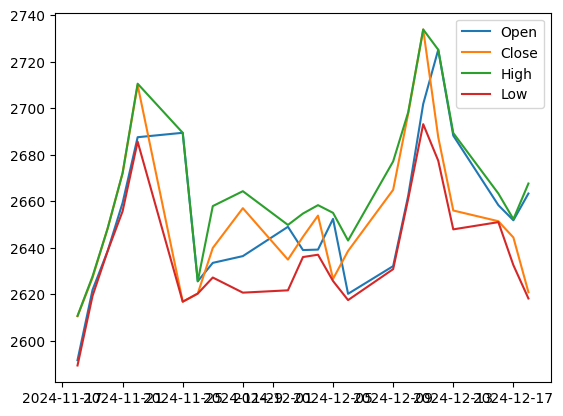

In [7]:
plt.plot(data['Open'])
plt.plot(data['Close'])
plt.plot(data["High"])
plt.plot(data['Low'])
plt.legend(['Open','Close','High','Low'])

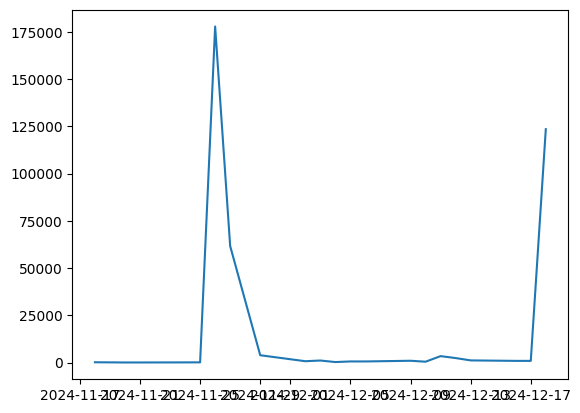

In [8]:
plt.plot(data['Volume'])

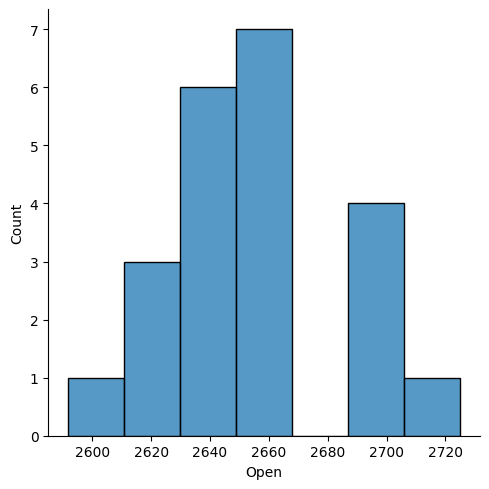

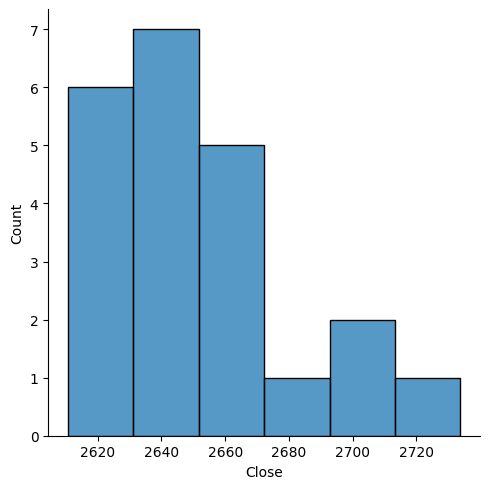

In [9]:
import seaborn as sns
sns.displot(data["Open"])
sns.displot(data["Close"])

In [10]:
corr_matrix=data[["Open","Close","High","Low","Volume"]].corr(numeric_only=True)


<Axes: >

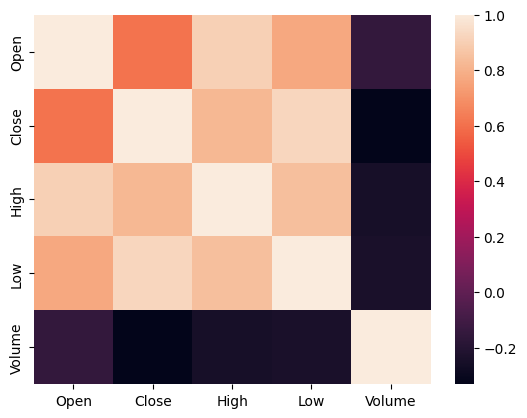

In [11]:
sns.heatmap(corr_matrix)


The gold index is very stable index,
The opening price is most often the low price and the closing price can vary but is closer to the high price.
Based on the month observation, it ends with a rise in price and volume, if it follows the same trend as the previous sharp increase in price and volume in the month, it should increase a bit before crashing.

## 1.3 - Creating a Stock Dataset


### Features
In this section, we will process a stock dataset containing multiple features. We will focus on utilizing the **attention mechanism** to process five specific features:

- **Open**
- **High**
- **Low**
- **Close**
- **Volume**

### Sliding Window Approach

We will use a *sliding, non-overlapping* window of size $N_{window}$ to generate input-output pairs. The input for each sequence will consist of the previous $N_{window}$ time steps, and the output will be the following $N_{window}$ time steps. Specifically, we aim to approximate the following relationship:

$$
f(W_t) \approx W_{t+1}
$$

Where:

$$
W_t = (p_{t_{w}}, p_{t_{w+1}}, \dots, p_{t_{w+N_{window}-1}})
$$

Example for $N_{window} = 3$

- **Input 1**: $[p_0, p_1, p_2]$  
  **Label 1**: $[p_3, p_4, p_5]$

- **Input 2**: $[p_3, p_4, p_5]$  
  **Label 2**: $[p_6, p_7, p_8]$

- **Input 3**: $[p_6, p_7, p_8]$  
  **Label 3**: $[p_9, p_{10}, p_{11}]$


### Dataset class

We will construct a dataset compatible with PyTorch's `Dataset` class. The custom dataset will take the following inputs:
- **Dataframe(s)** containing the stock data.
- **$N_{window}$**: The length of the sequence, representing the window size.
- normalized: A boolean indicating whether to normalize the data (Min-Max scaling to [-1, 1]).
- num_steps: The number of steps between consecutive data points. This parameter allows for the creation of sequences with a gap between each data point, enabling the model to learn from more diverse patterns.

Since we are dealing with time series data, which is inherently sequential, each data point $p_{i}$ belongs to a sequence of length $N_{window}$. The goal is to predict the future behavior of the stock based on past observations.

The `__getitem__` method should return a dictionary containing the following:
- **`dict['input']`**: A list of $N_{window}$ input values.
- **`dict['label']`**: A list of $N_{window}$ target values (the future values the model needs to predict).  



In [12]:
class StockDataset(Dataset):
    def __init__(self, df, N_window, normalized=True, num_steps=1):
        self.df = df
        self.df.dropna(how="any", axis=0, inplace=True)
        self.N_window = N_window
        self.num_steps = num_steps
        self.normalized = normalized
        self.X, self.y = self.process_df()

    def process_df(self):
        """
        process method should return X,y:
        * X is an array of num_steps*N_windows input values
        * y is an array of corresponding target values
        """
        scaler = MinMaxScaler(feature_range=(-1, 1))
        data_raw = self.df.to_numpy()
        close = self.df["Close"].to_numpy()
        open = self.df["Open"].to_numpy()
        high = self.df["High"].to_numpy()
        low = self.df["Low"].to_numpy()
        volume = self.df["Volume"].to_numpy()

        if self.normalized:
            close = scaler.fit_transform(close.reshape(-1, 1))
            open = scaler.fit_transform(open.reshape(-1, 1))
            high = scaler.fit_transform(high.reshape(-1, 1))
            low = scaler.fit_transform(low.reshape(-1, 1))
            volume = scaler.fit_transform(volume.reshape(-1, 1))
        assert len(close) == len(open) == len(high) == len(low) == len(volume)
        data_raw = np.hstack([close, open, high, low, volume])

        print(data_raw.shape)
        
        # TODO : Create a list of non-overlaping sequences of N_window elements
        windows = []
        targets = []
        for i in range(len(data_raw) - 2*self.N_window - self.num_steps + 1):
            window = data_raw[i:i + self.N_window]
            target = data_raw[i+self.N_window+self.num_steps:i + 2*self.N_window+self.num_steps]  
            windows.append(window)
            targets.append(target)

        # TODO : Return an array of sequences where X is the input values and y the target values
        X = X = np.array(windows)
        y = np.array(targets)
        return X, y

    def __len__(self):
        """
        Be careful on your len because of the overlapping issues
        """
        # TODO : What is the len of the dataset ?
        return len(self.X)

    def __getitem__(self, idx):
        """
        __getitem__ method should return a dictionnary where :
        * dict['input'] : is a list of num_{steps} lists of N_{window} elements
        * dict['label'] : is a list of N_{window} target value
        """
        # TODO : Return one element
        x = self.X[idx]
        y = self.y[idx]
        return {"input": x, "label": y}




In [13]:
df = data
N_window = 3
normalized = True
dataset = StockDataset(df, N_window, normalized)
#stride 1 = No overlap + 1 value skipped

print(dataset[0]["input"])
print(dataset[0]["label"])

assert dataset[0]["input"].shape == (N_window, 5)
assert dataset[0]["label"].shape == (N_window, 5)

(22, 5)
[[-1.         -1.         -1.         -1.         -0.99877412]
 [-0.73214275 -0.54722762 -0.72380201 -0.42333481 -0.9993252 ]
 [-0.38961253 -0.29835086 -0.39073972 -0.05303751 -1.        ]]
[[ 0.61201046  0.43628101  0.62144549  0.85535225 -0.99984255]
 [-0.8993514   0.46476528  0.27863345 -0.47155073 -0.99924648]
 [-0.8425332  -0.49175248 -0.7579182  -0.40404844  1.        ]]


At this moment, each samples will be a dictionnary with a sequence. However, one important feature is hidden in our stock price but we need a proper way to use it. 
* What feature are we talking about ?


The date

## 1.4 - Creating the Lightning DataModule

As usual create a Lightning Datamodule that encompasses everything. 

In [14]:
class StockDataModule(pl.LightningDataModule):
    def __init__(self, df, N_window, normalized, batch_size):
        super().__init__()
        self.df = df
        self.N_window = N_window
        self.normalized = normalized
        self.batch_size = batch_size


    def setup(self, stage):
        # First stage is 'fit' (or None)

        # TODO : Do we shuffle the datasets ? Why ?
        #Don't shuffle the dataset : the date and time correlation are very important in this study
        X_train, X_test = train_test_split(self.df,test_size=0.2, shuffle=False)
        X_train, X_valid = train_test_split(X_train,test_size=0.2, shuffle=False)

        if stage == "fit" or stage is None:
            # We create a validation split to watch the training.
            # TODO : As usual
            self.stock_train = StockDataset(X_train,self.N_window,self.normalized)
            self.stock_valid = StockDataset(X_valid,self.N_window,self.normalized)

        # Second stage is 'test'
        if stage == "test" or stage is None:
            # TODO : As usual
            self.stock_test = StockDataset(X_test,self.N_window,self.normalized)

    def train_dataloader(self):
        return DataLoader(self.stock_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.stock_valid, self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.stock_test, self.batch_size, shuffle=True)

In [15]:
# TODO : Initialize your datamodule

dm = StockDataModule(data,N_window=2,normalized=True,batch_size=4)
dm.setup(stage="fit")


(13, 5)
(4, 5)


In [16]:
test_features, test_labels = next(iter(dm.train_dataloader()))
print(test_features,test_labels)

input label


## 2 - Positional Encoding : Incorporating Time to the features with Time2Vector

As we have seen, transformers are not able to understand the order of the data.
Usually, the original mechanism to encode the position of the data is to use a positional encoding. However, this encoding doesn't provide any sense of time.

One proposed solution is to use a [Time2Vector](https://arxiv.org/abs/1907.05321) layer to encode the time information. The Time2Vector layer is a simple neural network layer that converts time into a vector representation. This vector representation can then be concatenated with the input features to provide the model with temporal information.

Time2Vector is a model-agnostic vector representation for time. The main idea of this vector is that : 
* a meaningful representation of time has to include both periodic and non-periodic patterns.
* a time representation should have an invariance to time rescaling

$$ \texttt{t2v}(\tau)[i] =
  \begin{cases}
    \omega_i \tau + \varphi_i, & \text{if~~$i=0$} \\
    \mathcal{F}(\omega_i \tau + \varphi_i), & \text{if~~$1 \leq i \leq k$}
  \end{cases} $$
* $\tau$ is the time (scalar)
* $\texttt{t2v}(\tau)[i]$ is the i-th component of the time2vector representation of $\tau$
* $\mathcal{F}$ is a periodic function for e.g. sin or cos
* $w_i$, $\varphi_{i}$   are learnable parameters

Let's create a Time2Vec Layer. We need non-periodic feature and a periodic feature.
* To your opinion is there a useless feature to exclude of this time embedding ?
* Why ?

**Important Disclaimer : Usually we add our positional encoding to our input tensor. However, in our case we will concatenate it.**


I am not a finance expert but all features here seem relevant. I think the leask relevant would be the opening or closing because they would be a bit redudndant. And even though the volume feature seems uncorrelated to the other according to the table, the volume of transactions clearly spike when the gold value rises.

In [24]:
import torch
from torch import nn
import numpy as np
import math

class Time2Vector(nn.Module):

  def __init__(self,in_features):
      super().__init__()
      self.in_features = in_features 
      self.w0 = nn.parameter.Parameter(torch.randn(1,1), requires_grad =True)
      self.b0 = nn.parameter.Parameter(torch.randn(in_features, 1), requires_grad =True)
      self.w = nn.parameter.Parameter(torch.randn(1,1), requires_grad =True)
      self.b = nn.parameter.Parameter(torch.randn(in_features, 1), requires_grad =True)
      self.f = torch.sin


  def forward(self,x):
      bs,seq_len,n_feat = x.shape
      # TODO : Exclude the unwanted feature and compute the mean along the last axis
      x = torch.mean(x,axis=-1)

      linear = x.unsqueeze(-1) 
      periodic = x.unsqueeze(-1)
      linear = torch.matmul(linear,self.w0) + self.b0 
      W = self.w.repeat(bs,1,1)
      b = self.b.repeat(bs,1,1)
      periodic = self.f(torch.bmm(periodic,W) + b) 
      return torch.cat([linear, periodic], -1).permute(0,2,1)

# TODO : Verify the output of Time2Vector shape. It should be of shape (Batch Size, Sequence Length, 2)
test = Time2Vector(5)

### III - Transformer : A Big Model around Attention

We are going to build each modules of our Transformer model. The heart of the model resides in the Attention Mecanism. The goal of the Attention mecanism is to force the model to look at specific part of the input. We will build each component of the transformer part by part.


Create the different components of the Transformer Encoder : 
* Attention Module
* Multi-Head Attention Module
* Transformer Encoder Layer
* Transformer Encoder

#### a - Attention layer

Let's compute the attention layer. We will create a layer that computes Bandhanau's attention also called Dot Scale Product attention. The attention mecanism takes an input $X$ and project it using a set of queries, keys and values. Think of it as a Database which you query (with the queries) using a set of keys, which returns a set values.

Mathematicaly speaking, we are computing the scaled dot product between $Q$, $K$, $V$


The attention is : 

$$ \text{Attention}(Q,K,V) =  \text{Softmax}\left(\frac{Q~K^T}{\sqrt{dim}}\right) \cdot  V $$

<img src="https://production-media.paperswithcode.com/methods/SCALDE.png" height = 400>



In [25]:
class Attention(nn.Module):
    def __init__(self, dim_query):
        super().__init__()
        self.dim_query = dim_query

    def forward(self, q, k, v):
        # TODO : Compute the attention mecanism between q,k,v
        attn = torch.bmm(q,k)/math.sqrt(self.dim_query)
        attn = F.softmax(attn,-1)
        context = torch.bmm(attn,v)
        return context, attn


#### b - Multi head Attention 

Usually, we like creating a Multi-Head Attention layer. Multi-Head only means that we are computing the attention over multiple heads. In fact, instead of having only one function computed by the attention mecanism, we leave each head free to learn a different function. Hence, we will have different outputs each computing a different value.

Mathematically speaking : 

$MultiHead(Q,K,V)=Concat(head_1,…,head_h)W^O$

with $head_i=Attention(QW_i^Q,KW_i^K,VW_i^V).$


<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTv6Bgq7bdnXdT-JDWEnnzK2EM1xY0NUEOyBg&usqp=CAU'>

 Question :    
 * What is $W^O$ ? Is it a learned parameter ?

Wo is a rescaling factor, not a learned parameter.

In [26]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, dim_query, dim_value, num_heads):
        super().__init__()

        # Embed dim is the shape of the feature space
        self.embed_dim = embed_dim
        # Num Heads is the number of heads
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.w_query = nn.Linear(embed_dim, num_heads * dim_query)
        self.w_key = nn.Linear(embed_dim, num_heads * dim_query)
        self.w_value = nn.Linear(embed_dim, num_heads * dim_value)
        self.linear = nn.Linear(num_heads * dim_value, embed_dim)
        # Dim Query, Dim Value are the projected dimensions of each tensors
        self.attention = Attention(dim_query)

    def forward(self, query, key, value):
        # TODO : Project your query, key, value into their respective heads
        q = self.w_query(query)
        k = self.w_key(key)
        v = self.w_value(value)
        # TODO : Compute the attention
        attn, context  = self.attention(q,k,v)
        attn = self.linear(attn)
        return attn, context

#### c - Transforming the Transformer

So let's create our Transformer model. We will just create the Encoder, as we don't need the Decoder in our case. We are just trying to Encode the input and find interesting patterns.
Usually we code the Transformer Model into a specific format :
* Layer Class
* Model Class

<img src="https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm" height=400>

In [21]:
# TODO : Create one Transformer Encoder Layer
class TransformerEncoderLayer(nn.Module):
    def __init__(
        self,
        embed_dim,
        dim_query,
        dim_value,
        num_heads,
        dim_feedforward=256,
        dropout=0.1,
    ):
        super().__init__()
        self.attention = MultiHeadAttention(embed_dim, dim_query, dim_value, num_heads)

        self.linear = nn.Sequential(
            nn.Linear(embed_dim, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(dim_feedforward, embed_dim),
        )

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, sequence):
        q = k = v = sequence.double()
        # TODO : Compute the attention
        attn, context  = self.attention(q,k,v)
        sequence = sequence + self.dropout1(attn)
        sequence = self.norm1(sequence)
        sequence = self.linear(sequence)
        sequence = sequence + self.dropout2(sequence)
        sequence = self.norm2(sequence)
        return sequence


# TODO : Create a Transformer Encoder.
class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super().__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers

    def forward(self, sequence):
        output = sequence.permute(2, 0, 1)
        for layer in self.layers:
            # TODO : Send your Input to your transformer
            output = layer(output)
        return output


#### Building the entire model 

Finally let's build the entire model. Let's use Pytorch-Lightning to encompass everything. 
Normally your model must be composed of three components : 
* The Transformer
* The Time2Vector 
* A Regression Head 

As usual ask yourself what task you are performing, how your data should travle trhough the model, what the data is, blablablablalablba

Don't forget to use your favorite logger.

In [22]:
class StockModel(pl.LightningModule):
    def __init__(self, embed_dim, dim_query, dim_value, num_layers, num_heads):
        super().__init__()
        self.save_hyperparameters()
        # TODO : Define your model here, be careful, your model will be an instance of the class. Watch  out for the input data.
        # TOOD : Define your Encoder Layer
        encoder_layer = TransformerEncoderLayer(
            embed_dim=embed_dim,  # TODO : What should be the hidden dim ?
            dim_query=dim_query,
            dim_value=dim_value,
            num_heads=num_heads,
            dim_feedforward=256,
            dropout=0.1,
        )

        # TODO : Initialize your Transformer
        self.transformer = TransformerEncoder(encoder_layer=encoder_layer, num_layers=256)
        # TODO : Initialize your regression head
        self.head = nn.Linear(num_heads*dim_value, embed_dim)  # What is your input hidden dim, output hidden dim ? Don't forget your time embedding
        # TODO : Initialize your Time2Vector Embeddings
        self.timeencoder = Time2Vector(embed_dim)  # What is the in_features dimension ? Is it the same as the input ?

    def forward(self, x):
        bs, h, len = x.shape
        pos = x.permute(0, 2, 1)
        time_vec = self.timeencoder(pos)
        # TODO : Concatenate your time embedding to the input sequence
        x = torch.cat(
            ...
        )  # TODO : Verify that the tensor was correctly concatenated within the feature dim
        # TODO : Send your input through your transformer
        x = self.transformer(x)
        x = x.view(bs * len, -1)
        # TODO : Send your input through the regression head
        x = self.head(x)
        x = x.view(bs, -1, len)
        return x

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        return optimizer

    def training_step(self, batch, batch_idx):
        # TODO : Define your Training Step
        X, y = ...
        out = ...
        loss = ...
        # Don't remove the next line, you will understand why later
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        # TODO : Define your Validation Step
        X, y = ...
        out = ...
        loss = ...
        # Don't remove the next line, you will understand why later
        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        # TODO : Define your Test Step
        X, y = ...
        out = ...
        loss = ...
        self.log("test_loss", loss)


## IV - Training the Model

* Initialize a model with 3 stacks of Encoder with 8 heads.
* What is the Embed Dimension ?
* What is the Dimension of a Query, Key and Value ? 



In [23]:
# TODO : Initalize Model, Datamodule and Trainer
embed_dim = ...
num_heads = ...
dim_query = ...
dim_value = ...
num_layers = ...

model = StockModel(
    embed_dim=..., dim_query=..., dim_value=..., num_layers=..., num_heads=...
).double()


dm = ...

trainer = ...


TypeError: unsupported operand type(s) for //: 'ellipsis' and 'ellipsis'

In [ ]:
# TODO : Fit the Data to the Model

## V - Testing the model : Inference 

Now that the model is trained, testing it is a key to become rich.

#### a - Testings 

Test the model on the test dataset.

* What happens ?
* What can we do to enhance the results ?
* Will you deploy the model ?
* What are your predictions for next week ? Can we invest or not ?

**Illustrate your arguments using charts or any kind of visual materials supporting your analysis. Any non illustrated analysis won't be taken into account**

#### b - Further Testings 

Test the model on a different dataset.
* What can you say ?
* What are your predictions for next week ? Can we invest or not ?

**Illustrate your arguments using charts or any kind of visual materials supporting your analysis. Any non illustrated analysis won't be taken into account**
